In [1]:
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np

# Exploring
import scipy.stats as stats

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# default pandas decimal number display format
pd.options.display.float_format = '{:.2f}'.format

# Acquiring
from env import host, user, password 
import os

import wrangle

# Preparing -  split and scale
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

### 1. Acquire data from mall_customers.customers in mysql database.

In [4]:
sql = 'select * from customers'

def get_db_url(database):
    from env import host, user, password
    url = f'mysql+pymysql://{user}:{password}@{host}/{database}'
    return url

# acquire mall customers data using the query:
def get_mall_customers(sql):
    url = get_db_url('mall_customers')
    mall_df = pd.read_sql(sql, url, index_col='customer_id')
    return mall_df

In [5]:
# acquire data

mall_df = get_mall_customers(sql)

mall_df.head()

,gender,age,annual_income,spending_score
customer_id,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


### 2. Summarize data (include distributions and descriptive statistics).

In [6]:
mall_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          200 non-null    object
 1   age             200 non-null    int64 
 2   annual_income   200 non-null    int64 
 3   spending_score  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


In [7]:
mall_df.shape

(200, 4)

In [8]:
mall_df.describe()

,age,annual_income,spending_score
count,200.00,200.00,200.00
mean,38.85,60.56,50.20
std,13.97,26.26,25.82
min,18.00,15.00,1.00
25%,28.75,41.50,34.75
50%,36.00,61.50,50.00
75%,49.00,78.00,73.00
max,70.00,137.00,99.00


In [9]:
mall_df.isnull().sum()

gender            0
age               0
annual_income     0
spending_score    0
dtype: int64

In [10]:
mall_df.gender.value_counts()

Female    112
Male       88
Name: gender, dtype: int64

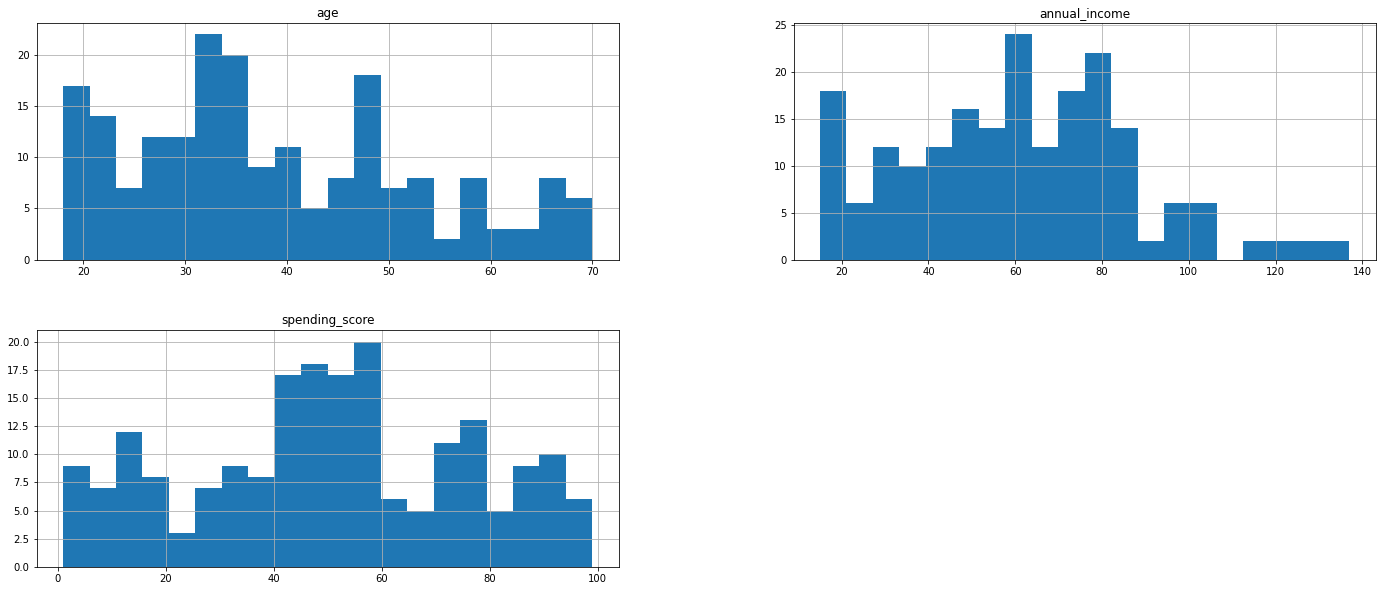

In [11]:
mall_df.hist(figsize=(24, 10), bins=20);

<AxesSubplot:ylabel='spending_score'>

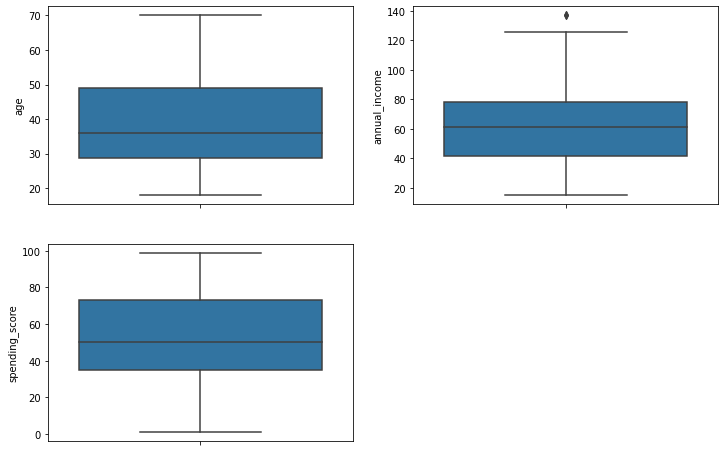

In [12]:
# visualize outliers using boxplots:

plt.figure(figsize = (12,8))
plt.subplot(221)
sns.boxplot(y = mall_df.age)

plt.subplot(222)
sns.boxplot(y = mall_df.annual_income)

plt.subplot(223)
sns.boxplot(y = mall_df.spending_score)

### 3. Detect outliers using IQR.

In [13]:
# Calculate q1, q3 and iqr for income

q1 = mall_df.annual_income.quantile(0.25)
q3 = mall_df.annual_income.quantile(0.75)
iqr = q3 - q1
k = 1.5

# calculate upper and lower ranges
upper_bound_income =  q3 + k * iqr
lower_bound_income =  q1 - k * iqr

upper_bound_income

132.75

In [14]:
# function to detect and eliminate outliers using IQR rule

def outlier_function(df, cols, k):
    for col in df[cols]:
        q1 = mall_df.annual_income.quantile(0.25)
        q3 = mall_df.annual_income.quantile(0.75)
        iqr = q3 - q1
        upper_bound =  q3 + k * iqr
        lower_bound =  q1 - k * iqr     
        df = df[(df[col] < upper_bound) & (df[col] > lower_bound)]
    return df

In [15]:
# use the outlier function defined above to handle outliers in numeric columns. k = 1.5

mall_df = outlier_function(mall_df, ['age', 'spending_score', 'annual_income'], 1.5)
mall_df.shape

(198, 4)

### 4. Split data (train, validate, and test split).

In [16]:
train, test = train_test_split(mall_df, train_size = 0.8, random_state = 123)
train, validate = train_test_split(train, train_size = 0.75, random_state = 123)

In [17]:
# check shape
train.shape, validate.shape, test.shape

((118, 4), (40, 4), (40, 4))

### 5. Encode categorical columns using a one hot encoder.

In [18]:

# encode the gender column

dummy_df = pd.get_dummies(mall_df.gender, drop_first=True)
dummy_df.head()

,Male
customer_id,
1,1
2,1
3,0
4,0
5,0


In [19]:
# concat the dummies df with original df. Drop the 'gender' column

mall_df = pd.concat([mall_df, dummy_df], axis=1).drop(columns = ['gender'])
mall_df.head()

,age,annual_income,spending_score,Male
customer_id,,,,
1,19,15,39,1
2,21,15,81,1
3,20,16,6,0
4,23,16,77,0
5,31,17,40,0


### 6. Handles missing values.

In [20]:
#no missing values
mall_df.isnull().sum()

age               0
annual_income     0
spending_score    0
Male              0
dtype: int64

### 7. Scaling

In [21]:
def min_max_scaler(train, valid, test):
    '''
    Uses the train & test datasets created by the split_my_data function
    Returns 3 items: mm_scaler, train_scaled_mm, test_scaled_mm
    This is a linear transformation. Values will lie between 0 and 1
    '''
    num_vars = list(train.select_dtypes('number').columns)
    scaler = MinMaxScaler(copy=True, feature_range=(0,1))
    train[num_vars] = scaler.fit_transform(train[num_vars])
    valid[num_vars] = scaler.transform(valid[num_vars])
    test[num_vars] = scaler.transform(test[num_vars])
    return scaler, train, valid, test

In [22]:
train.select_dtypes('number').columns

Index(['age', 'annual_income', 'spending_score'], dtype='object')

In [23]:
# use the scaler
scaler, train_scaled, validate_scaled, test_scaled = min_max_scaler(train, validate, test)

In [24]:
train_scaled.head()

,gender,age,annual_income,spending_score
customer_id,,,,
182,Female,0.27,0.74,0.87
49,Female,0.21,0.23,0.42
35,Female,0.60,0.16,0.13
186,Male,0.23,0.76,0.98
114,Male,0.02,0.44,0.46


**wrangle_mall.py**
1. Acquire data from mall_customers.customers in mysql database.
2. Split the data into train, validate, and split
3. One-hot-encoding
4. Missing values
5. Scaling

In [25]:
# Write a master wrangle fuction which acquires and prepares the data

def wrangle_mall_df():
    
    # acquire data
    sql = 'select * from customers'
    mall_df = get_mall_customers(sql)
    
    # handle outliers
    mall_df = outlier_function(mall_df, ['age', 'spending_score', 'annual_income'], 1.5)
    
    # get dummy for gender column
    dummy_df = pd.get_dummies(mall_df.gender, drop_first=True)
    mall_df = pd.concat([mall_df, dummy_df], axis=1).drop(columns = ['gender'])

    # split the data in train, validate and test
    train, test = train_test_split(mall_df, train_size = 0.8, random_state = 123)
    train, validate = train_test_split(train, train_size = 0.75, random_state = 123)
    
    return min_max_scaler(train, validate, test)

In [26]:
# use the wrangle function:

scaler, train_scaled, validate_scaled, test_scaled = wrangle_mall_df()

In [27]:
train_scaled.head(3)

,age,annual_income,spending_score,Male
customer_id,,,,
182,0.27,0.74,0.87,0.00
49,0.21,0.23,0.42,0.00
35,0.60,0.16,0.13,0.00


In [28]:
train_scaled.shape, validate_scaled.shape, test_scaled.shape

((118, 4), (40, 4), (40, 4))

In [29]:
# check if wrangle.py works as intended for mall_customers:

scaler, train_scaled, validate_scaled, test_scaled = wrangle.wrangle_mall_df()

In [30]:
train_scaled.head(3)

,age,annual_income,spending_score,Male
customer_id,,,,
182,0.27,0.74,0.87,0.00
49,0.21,0.23,0.42,0.00
35,0.60,0.16,0.13,0.00
